In [85]:
import numpy as np
import xarray as xr
import pandas as pd
from datetime import date, datetime

import ecco_v4_py as ecco
from ecco_v4_py import get_basin

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/').rename({'face': 'tile'})

In [3]:
x_vol = (main['UVELMASS'] + main['UVELSTAR']) * main['drF'] * main['dyG']
y_vol = (main['VVELMASS'] + main['VVELSTAR']) * main['drF'] * main['dxG']

In [4]:
x_heat = main['ADVx_TH'] + main['DFxE_TH']
y_heat = main['ADVy_TH'] + main['DFyE_TH']

In [5]:
x_salt = main['ADVx_SLT'] + main['DFxE_SLT']
y_salt = main['ADVy_SLT'] + main['DFyE_SLT']

In [6]:
grid = ecco.get_llc_grid(main)

In [17]:
# Define constants

# Density kg/m^3
rhoconst = 1029

# Heat capacity (J/kg/K)
c_p = 3994

# Watts to Petawatts
pw = 1e-15

# m^3 to Sverdrup
Sv = 10**-6

In [8]:
def get_basin_mask(basin_name,mask):
    """Return mask for ocean basin.
    Note: This mirrors gcmfaces/ecco_v4/v4_basin.m

    Parameters
    ----------
    basin_name : string or list
        name of basin to include, options are any of the following

        atlExt - atl, mexico, hudson, med, north, baffin, gin
        pacExt - pac, bering, okhotsk, japan, eastChina
        indExt - ind, southChina, java, timor, red, gulf
        arct, barents

    mask : xarray DataArray
        2D or 3D mask for open ocean
        Note: can be at centers, west, or south face

    Returns
    -------
    basin_mask : xarray DataArray
        mask with values at cell centers, 1's for denoted ocean basin
        dimensions are the same as input field
    """

    if type(basin_name) is not list:
        basin_name = [basin_name]

    # Look for extended basins
    basin_name = get_basin._append_extended_basins(basin_name)

    # Get available names
    available_names = ecco.get_available_basin_names()

    # Read binary with the masks, from gcmfaces package
    bin_dir = '/mnt/efs/ECCOv4-py/bin'
    all_basins = ecco.read_llc_to_tiles(bin_dir,'basins.data')

    # Handle vertical coordinate
    # If input mask is 3D in space, first get mask on top level
    if 'k' in mask.dims:
        mask_2d = mask.isel(k=0)
    elif 'k_u' in mask.dims:
        mask_2d = mask.isel(k_u=0)
    elif 'k_l' in mask.dims:
        mask_2d = mask.isel(k_l=0)
    elif 'k_p1' in mask.dims:
        mask_2d = mask.isel(k_p1=0)
    else:
        mask_2d = mask

    basin_mask = 0*mask_2d

    for name in basin_name:
        if name in available_names:
            basin_mask = basin_mask + mask_2d.where(all_basins == (available_names.index(name)+1),0)
        else:
            warnings.warn('\nIgnoring %s, not an available basin mask.\n '
                          'Available basin mask names are: %s' % (name,available_names))

    # Now multiply by original mask to get vertical coordinate back
    # (xarray multiplication implies union of dimensions)
    basin_mask = basin_mask * mask

    return basin_mask

In [9]:
maskW = main.hFacW.where(main.hFacW>0, np.nan)
maskS = main.hFacS.where(main.hFacS>0, np.nan)

In [10]:
basin_maskW = get_basin_mask(['atlExt'],maskW.isel(k=0))
basin_maskS = get_basin_mask(['atlExt'],maskS.isel(k=0))

loading  basins.data
data shape  (1170, 90)
dims, num_dims, llc  (1170, 90) 2 90
2 dimensions
f3 shape  (90, 90)
f5 shape  (90, 270)
2D, data_compact shape  (1170, 90)
data_tiles shape  (13, 90, 90)
data_tiles shape =  (13, 90, 90)
loading  basins.data
data shape  (1170, 90)
dims, num_dims, llc  (1170, 90) 2 90
2 dimensions
f3 shape  (90, 90)
f5 shape  (90, 270)
2D, data_compact shape  (1170, 90)
data_tiles shape  (13, 90, 90)
data_tiles shape =  (13, 90, 90)


In [12]:
lat_maskW, lat_maskS = ecco.vector_calc.get_latitude_masks([26], main.coords['YC'], grid)

In [14]:
lat_trsp_x = (x_vol * lat_maskW * basin_maskW).sum(dim=['i_g','j','tile'])
lat_trsp_y = (y_vol * lat_maskS * basin_maskS).sum(dim=['i','j_g','tile'])
vol_trsp = (lat_trsp_x + lat_trsp_y).sum('k').compute()*Sv

In [61]:
lat_trsp_x = (x_heat * lat_maskW * basin_maskW).sum(dim=['i_g','j','tile'])
lat_trsp_y = (y_heat * lat_maskS * basin_maskS).sum(dim=['i','j_g','tile'])
heat_trsp = (lat_trsp_x + lat_trsp_y).sum('k').compute()*rhoconst*c_p*pw

In [22]:
lat_trsp_x = (x_salt * lat_maskW * basin_maskW).sum(dim=['i_g','j','tile'])
lat_trsp_y = (y_salt * lat_maskS * basin_maskS).sum(dim=['i','j_g','tile'])
salt_trsp = (lat_trsp_x + lat_trsp_y).sum('k').compute()*Sv

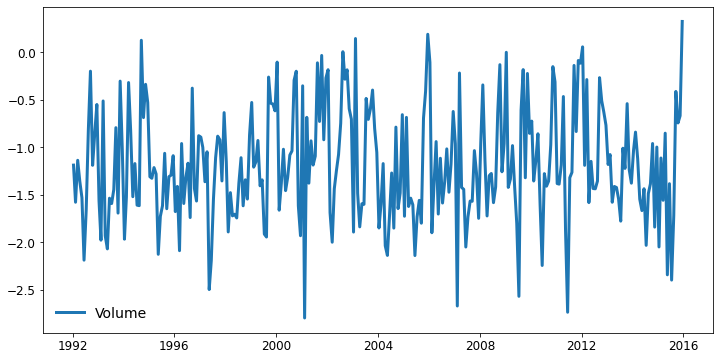

In [16]:
plt.figure(figsize=(12,6))
#plt.plot(df.time,df.fkl, lw=3, color='#1f77b4',label='Foukal and Lozier (2017)')
plt.plot(lat_trsp.time,lat_trsp, lw=3, color='#1f77b4',label='Volume')
plt.legend(frameon=False, loc='lower left', fontsize=14)
#plt.ylim([22,44])
plt.gca().tick_params(axis='both', which='major', labelsize=12)
plt.show()

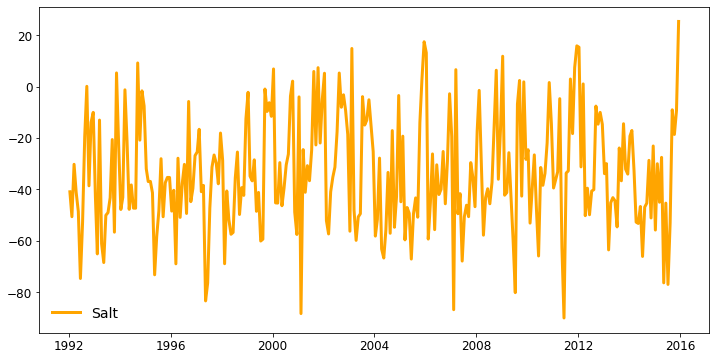

In [23]:
plt.figure(figsize=(12,6))
plt.plot(salt_trsp.time,salt_trsp, lw=3, color='orange',label='Salt')
plt.legend(frameon=False, loc='lower left', fontsize=14)
#plt.ylim([22,44])
plt.gca().tick_params(axis='both', which='major', labelsize=12)
plt.show()

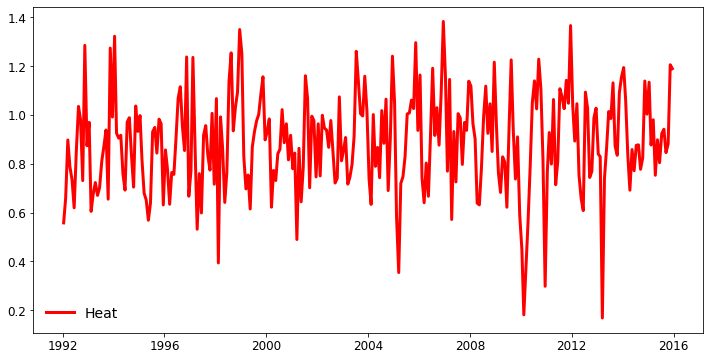

In [19]:
plt.figure(figsize=(12,6))
#plt.plot(df.time,df.fkl, lw=3, color='#1f77b4',label='Foukal and Lozier (2017)')
plt.plot(heat_trsp.time,heat_trsp, lw=3, color='r',label='Heat')
plt.legend(frameon=False, loc='lower left', fontsize=14)
#plt.ylim([22,44])
plt.gca().tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [24]:
lat_trsp_x = (x_vol * lat_maskW * basin_maskW).sum(dim=['i_g','j','tile'])
lat_trsp_y = (y_vol * lat_maskS * basin_maskS).sum(dim=['i','j_g','tile'])

In [31]:
psi_moc = (lat_trsp_x + lat_trsp_y).isel(k=slice(None,None,-1)).cumsum(dim='k')

In [33]:
psi_moc = -1 * psi_moc.isel(k=slice(None,None,-1))

In [40]:
psi_moc.coords['Z'] = main.coords['Z']

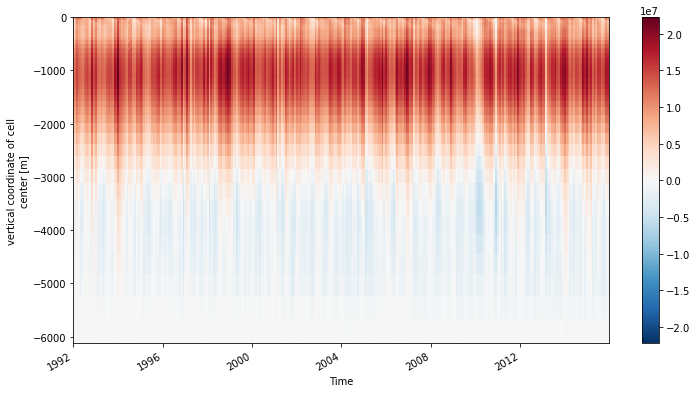

In [45]:
psi_moc.swap_dims({'k': 'Z'}).T.plot(figsize=(12,6))

In [49]:
# Compute overturning strength
moc = psi_moc.max(dim='k').compute()*Sv

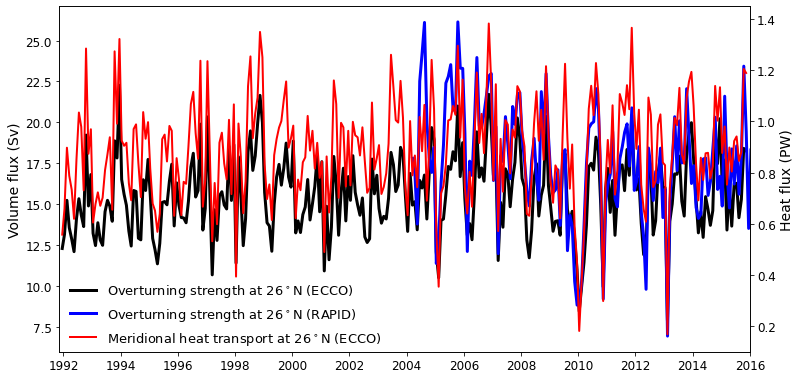

In [121]:
fig, ax1 = plt.subplots(figsize=(12,6))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

ax1.plot(moc.time,moc, lw=3, color='k',label=r'Overturning strength at 26$^\circ$N (ECCO)')
ax1.plot(moc_rapid.time,moc_rapid, lw=3, color='b',label=r'Overturning strength at 26$^\circ$N (RAPID)')


ax1.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])
ax1.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#ax1.set_ylim([-6.5e4,6.5e4])
ax1.tick_params(axis='both',labelsize=12)
ax1.set_ylabel('Volume flux (Sv)', color='k',fontsize=14)
ax1.legend(loc='lower left',frameon=False, bbox_to_anchor=(0, 0.05), fontsize=13)

ax2 = ax1.twinx()
ax2.plot(heat_trsp.time,heat_trsp, lw=2, color='r',label='Meridional heat transport at 26$^\circ$N (ECCO)')
ax2.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])
ax2.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.set_ylim([0.1,1.45])
ax2.tick_params(axis='both',labelsize=12)
ax2.set_ylabel(r'Heat flux (PW)', color='k', fontsize=14)
ax2.legend(loc='lower left',frameon=False, bbox_to_anchor=(0, -0.02), fontsize=13)

plt.savefig('/mnt/efs/figure.png')
plt.savefig('/mnt/efs/figure.eps')
plt.savefig('/mnt/efs/figure.pdf')
plt.show()

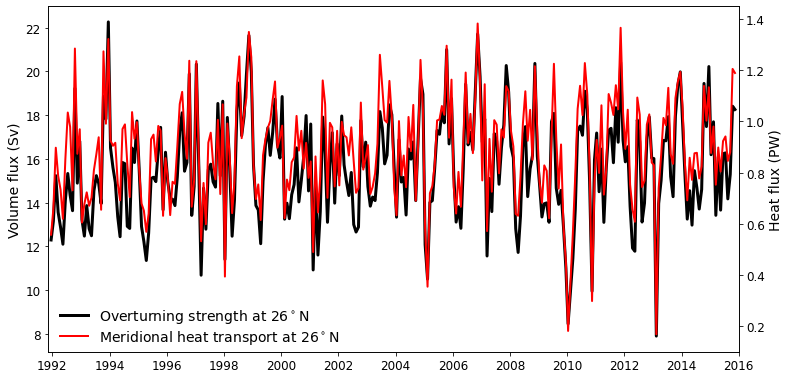

In [90]:
moc_anom = moc.groupby('time.month') - moc.groupby('time.month').mean('time')
heat_trsp_anom = heat_trsp.groupby('time.month') - heat_trsp.groupby('time.month').mean('time')

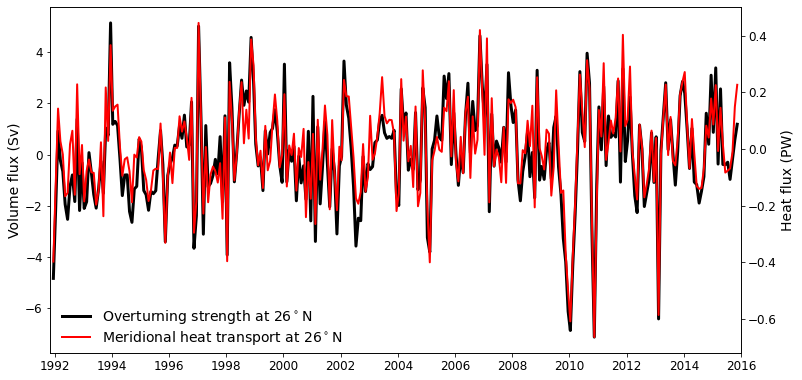

In [91]:
fig, ax1 = plt.subplots(figsize=(12,6))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

ax1.plot(moc_anom.time,moc_anom, lw=3, color='k',label=r'Overturning strength at 26$^\circ$N')
ax1.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])
ax1.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#ax1.set_ylim([-6.5e4,6.5e4])
ax1.tick_params(axis='both',labelsize=12)
ax1.set_ylabel('Volume flux (Sv)', color='k',fontsize=14)
ax1.legend(loc='lower left',frameon=False, bbox_to_anchor=(0, 0.04), fontsize=14)

ax2 = ax1.twinx()
ax2.plot(heat_trsp_anom.time,heat_trsp_anom, lw=2, color='r',label='Meridional heat transport at 26$^\circ$N')
ax2.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])
ax2.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#ax2.set_ylim([0.1,1.45])
ax2.tick_params(axis='both',labelsize=12)
ax2.set_ylabel(r'Heat flux (PW)', color='k', fontsize=14)
ax2.legend(loc='lower left',frameon=False, bbox_to_anchor=(0, -0.02), fontsize=14)

plt.show()

In [124]:
df = moc_anom.to_dataframe(name='moc').reset_index()
df['moc_ht'] = heat_trsp_anom.to_dataframe(name='moc_ht').reset_index().moc_ht
df.drop(columns=['dt','iter'],inplace=True)

In [126]:
df.time = pd.DatetimeIndex(df.time)
df.time = df.time.map(lambda x: datetime(x.year,x.month,15))

In [128]:
df.drop(columns=['month'],inplace=True)

In [129]:
df

,time,moc,moc_ht
0,1992-01-15,-4.836467,-0.397140
1,1992-02-15,-2.171671,-0.131029
2,1992-03-15,0.922694,0.143025
3,1992-04-15,-0.229755,0.027854
4,1992-05-15,-0.658416,-0.018714
...,...,...,...
283,2015-08-15,-0.297350,-0.076293
284,2015-09-15,-0.969279,-0.068522
285,2015-10-15,-0.175356,-0.011179
286,2015-11-15,0.573767,0.149078


In [95]:
df.to_csv('/mnt/efs/data/ecco/ecco_moc.csv', index=True)

In [131]:
df.set_index('time',inplace=True)
df['dt'] = main.reset_coords().dt.sel(time=slice('1993-01-01','2015-11-30')).to_dataframe().dt

In [132]:
# Annual
df_sub = df.loc[(df.index > '1992-12-31')&(df.index < '2015-01-01')]
df_1yr = df_sub.multiply(df_sub["dt"], axis="index").resample('1A',kind='period').sum().drop(columns=['dt'])

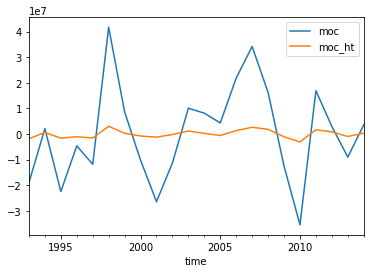

In [135]:
df_1yr.plot()

In [116]:
heat_trsp_int = (heat_trsp_anom.isel(time=slice(1, -1))*main.isel(time=slice(1, -1)).dt).cumsum(dim='time')
heat_anom = heat_trsp_int - heat_trsp_int.mean('time')

In [118]:
budgH = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_heat.nc').budg_heat
budgH_anom = budgH.groupby('time.month') - budgH.groupby('time.month').mean('time')
budgH_int = (budgH_anom.isel(time=slice(1, -1))*main.isel(time=slice(1, -1)).dt).cumsum(dim='time')
budgH_anom = budgH_int - budgH_int.mean('time')

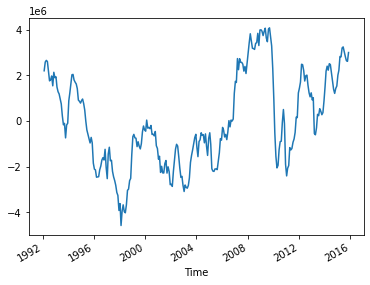

In [117]:
heat_anom*1e-22.plot()

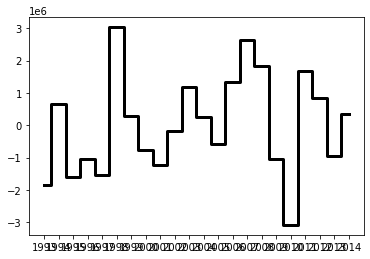

In [137]:
plt.step(df_1yr.index.strftime('%Y'), df_1yr.moc_ht, where='mid', c='k', lw=3, linestyle='-')


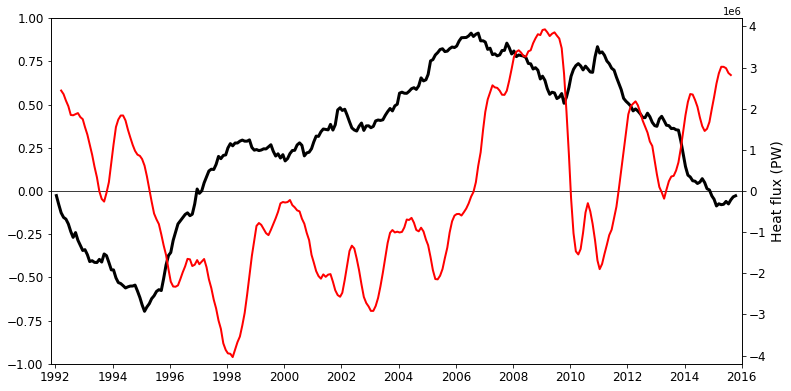

In [149]:
fig, ax1 = plt.subplots(figsize=(12,6))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
ax1.axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')

ax1.plot(budgH_int.time, budgH_int.sel(region='spna',term='adv_ConvH')*1e-22, lw=3, color='k',
         label=r'Advective heat convergence')

ax1.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])
ax1.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.set_ylim([-1,1])
ax1.tick_params(axis='both',labelsize=12)

ax2 = ax1.twinx()
ax2.axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')

ax2.plot(heat_anom.time,heat_anom.rolling(time=5,center=True).mean(), lw=2, color='r',
         label=r'Integrated meridional heat transport at 26$^\circ$N')
#ax2.step(df_1yr.index.strftime('%Y'), df_1yr.moc_ht, where='mid', c='k', lw=3, linestyle='-')
#ax2.plot(df.index, df.rolling(window=12,center=True).mean()['moc_ht'], lw=2, color='r',linestyle='-',
#         label='Meridional heat transport at 26$^\circ$N')
ax2.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])
ax2.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.set_ylim([-4.20e6,4.20e6])
ax2.tick_params(axis='both',labelsize=12)
ax2.set_ylabel(r'Heat flux (PW)', color='k', fontsize=14)
plt.show()

In [97]:
ds = xr.open_dataset('moc_transports.nc')

In [107]:
moc_rapid = ds.moc_mar_hc10.resample(time='1M',loffset='-15D').mean('time')

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


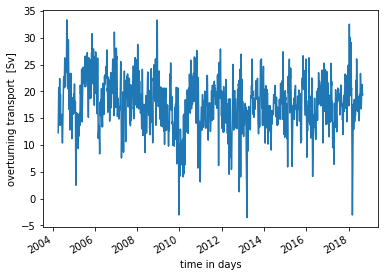

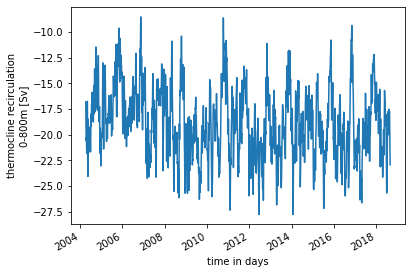

In [104]:
ds.t_therm10.plot()

In [105]:
ds.t_therm10.time

<xarray.DataArray 'time' (time: 10535)>
array(['2004-04-02T00:00:00.000000000', '2004-04-02T12:00:00.000000000',
       '2004-04-03T00:00:00.000000000', ..., '2018-09-02T00:00:00.000000000',
       '2018-09-02T12:00:00.000000000', '2018-09-03T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2004-04-02 2004-04-02T12:00:00 ... 2018-09-03
Attributes:
    long_name:  time in days